In [39]:
import sys
sys.path.append("../")

import dougnet as dn
from dougnet.nograph import MultiLayerPerceptron
from dougnet.training import DataLoader, ProgressHelper
from dougnet.data import LoadMNIST
from dougnet.metrics import accuracy
from dougnet.metrics import accuracy, r2
from dougnet.functions import (relu, 
                               tanh, 
                               softmax, 
                               softmax_cross_entropy_loss, 
                               l2regloss, 
                               sigmoid, 
                               identity,
                               l2loss)
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# DougNet

DougNet is a deep learning api written entirely in python (using numba for select functions for performance) intended as a pedogogical tool for understanding the inner-workings of a deep learning library.  The syntax and api of dougnet is very similar to pytorch and its main features are:

- a computational graph for automatic differentiation
- functions (like multi-channel convolution) specific to neural network models
- optimization algorithms for training neural networks
- initialization and regularization methods for neural networks
- utilities for fetching datasets and loading data during training

In this notebook I introduce some of the basic functionality of dougnet.  Specifically, I cover
- the forward method in dougnet
- the backward method in dougnet
- an MLP for classification on dougnet's computational graph
- an MLP for regression on dougnet's computational graph

# DougNet forward method

As a simple example to illustrate how a computation is performed on a dougnet computational graph, let's perform a simple computation only involving scalar values: $a(x-b)^2+c$, with $x=9$, $a=3$, $b=5$ and $c=7$.

To create a computational graph one must first instantiate the graph with `dn.ComputationGraph()`.  All subsequent nodes that are defined will be associated with this graph until a new computational graph instance is defined.  In dougnet there are 3 types of nodes:

1) **InputNode**:  This is the most basic type of node.  This node typically serves to hold data in its `output` attribute, such as a mini-batch design matrix, when training a neural network model.  Input nodes have no parents, only children.  Since we typically do not care to compute gradients of input data, gradients of input nodes are not computed during backprop.
2) **ParameterNode**:  A parameter node is identical to an input node with the exception that during backprop, gradients are computed for these nodes.  The gradient of a parameter node can be performed by calling its `backward` method.  A parameter node typically holds the parameters of a model, such as weight matrices and bias vectors.
3) **ComputationNode**:  This is most complicated type of node in dougnet.  A computation node has both parents and, if it is not the final node in the graph (in a topologically sorted sense), children as well.  During the forward phase to perform a computation on a computational graph, an individual computation node will grab the output from its parents, perform a computation with the output, and store the results in its own `output` attribute.  The computation can be performed by calling the `forward` method of a computational node.  During backprop, a computational node will receive upstream gradients with respect to its children and use these gradients to compute vector-Jacobian products so that the gradient with respect to its computation can be performed.  This can be performed by calling its `backward` method.


In [40]:
# a * (x - b)^2 + c
# x = 9
# a = 3
# b = 5
# c = 7

# Create a new graph
g1 = dn.ComputationGraph()

# Create parameters
a = dn.ParameterNode(3)                        
b = dn.ParameterNode(5)
c = dn.ParameterNode(7)

# Create input
x = dn.InputNode(9)

# Construct graph
z1 = dn.Subtract(x, b)
z2 = dn.Sqr(z1)
z3 = dn.Mult(a, z2)
o = dn.Add(z3, c)

print(f'result of computation: {3 * (9 - 5) ** 2 + 7}')
print(f'result of computation performed on computational graph: {o.forward()}')

result of computation: 55
result of computation performed on computational graph: 55


Printing a node will provide some basic information about the node.

In [47]:
print(x)
print("\n")
print(o)

Node(output=9,
children=['Subtract'])


Node(output=55,
parents=['Mult', 'ParameterNode'],
children=[])


A subset of magic methods (e.g., `__add__`, `__radd__`, etc...) for the Node class in dougnet have been defined so that we can code the forward pass more naturally, almost as if working with numpy arrays rather than instances of nodes in a graph.  The following syntax, where `X` , `Y`, `Z`  and `b` are all dougnet node instances, should work appropriately (with `X.output.shape = Y.output.shape = (m, n)`, `Z.output.shape = (n, p)` and `b.output.shape = (m, 1))`:

|operation                                                     |example usage            | equivalent to    |
|------------------------------------------------------        |--------------           |--------------    |
|element-wise addition with broadcasting if applicable         |`X + Y`, `X + b`, `X + 3`|`dn.Add(X, Y)`, `dn.Add(X, b)`, `dn.Add(X, 3)`|
|element-wise subtraction                                      |`X - Y`, `X - 3`         |`dn.Subtract(X, Y)`, `dn.Subtract(X, 3)`|
|multiplication, both element-size (hadamard) and scalar-tensor|`X * Y`, `5 * X`, `X * 5`|`dn.Mult(X, Y)`, `dn.Mult(5, X)`, `dn.Mult(X, 5)`|
|division, both element-size and scalar-tensor                 |`X / Y`, `5 / X`, `X / 5`|`dn.Divide(X, Y)`, `dn.Divide(5, X)`, `dn.Divide(X, 5)`|
|power                                                         |`X ** 3`                 |`dn.Power(X, 3)`|
|matrix multiplication                                         |`X @ Z`                  |`dn.MatMult(X, Z)`|
|basic slicing/indexing             |`X[0, 0]`, `X[:, 1]`, `X[2:5, 1]`, `X[[0, 4, 2], 1:3]`|`dn.Slice(X, (0, 0))`, `dn.Slice(X, (slice(None, None, None), 1))`, `dn.Slice(X, (slice(2, 5, None), 1))`, `dn.Slice(X, ([0, 4, 2], slice(1, 3, None)))`|

Let's re-perform the computation using this syntax:

In [15]:
# re-define graph
g1 = dn.ComputationGraph()

# Create parameters
a = dn.ParameterNode(3)                        
b = dn.ParameterNode(5)
c = dn.ParameterNode(7)

# Create input
x = dn.InputNode(9)

# Construct graph
z1 = x - b
z2 = z1 ** 2
z3 = a * z2
o = z3 + c

print(f'forward computation: {o.forward()}')

forward computation: 55


As a final, slightly more complex computation involving matrices and vectors, I compute $\sigma(\beta X + b)$, which could have the interpretation of being the output $P(Y=1|X)$ from logistic regression.

In [16]:
# compute output from a logistic regression P[Y=1|X] = s(beta @ X + b), with each data point in a X a column (not row)

# Create a new graph
g2 = dn.ComputationGraph()

# Create paramter nodes
beta = dn.ParameterNode(np.array([.5, .07, .1]))
b = dn.ParameterNode(.4)

# Create placeholder
X = dn.InputNode([[1, 2, -5], 
                  [3, 4, -2], 
                  [5, 6, -3]])

P_Yeq1_giv_x = dn.Sigmoid(dn.MatMult(beta, X) + b)
print(f'forward computation: {P_Yeq1_giv_x.forward()}')

forward computation: [0.83341139 0.90720705 0.07310117]


# DougNet backward method

In dougnet we can utilize the computational graph that is constructed to perform reverse mode automatic differentiation.  This will allow us to compute the gradient of a scalar valued function (such as a loss) with respect to all parameters in the graph.  In this section I illustrate the dougnet's autodiff functionality by differentiating the scalar valued function: $f(x) = \sqrt{x^2 + exp(x^2)} + \mathrm{cos}[x^2 + exp(x^2)]$.

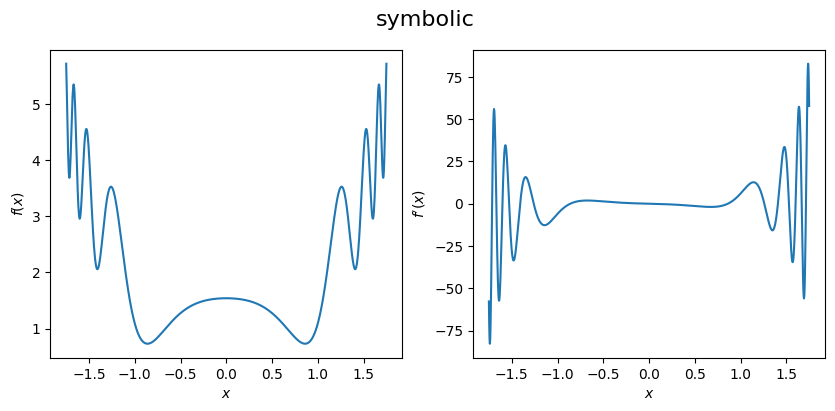

In [34]:
# first compute f(x) and f^prime(x) with symbolic differentiation and plot

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))

x = np.linspace(-1.75, 1.75, 1000)
y = np.sqrt(x**2 + np.exp(x**2)) + np.cos(x**2 + np.exp(x**2))
y_prime = x * (1./np.sqrt( x**2 + np.exp(x**2) ) - 2 * np.sin(x**2 + np.exp(x**2)) ) * (1. + np.exp(x ** 2))

ax1.plot(x, y)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$f(x)$")

ax2.plot(x, y_prime)
ax2.set_xlabel("$x$")
ax2.set_ylabel("$f^\prime(x)$")

fig.suptitle('symbolic', fontsize=16);

In [35]:
# create a computational graph in dougnet to perform required computation

#Create a new graph
g3 = dn.ComputationGraph()

x = dn.ParameterNode()
xsqr = x ** 2
xsqr_plus_exp_xsqr = xsqr + dn.Exp(xsqr)
o = dn.Sqrt(xsqr_plus_exp_xsqr) + dn.Cos(xsqr_plus_exp_xsqr)

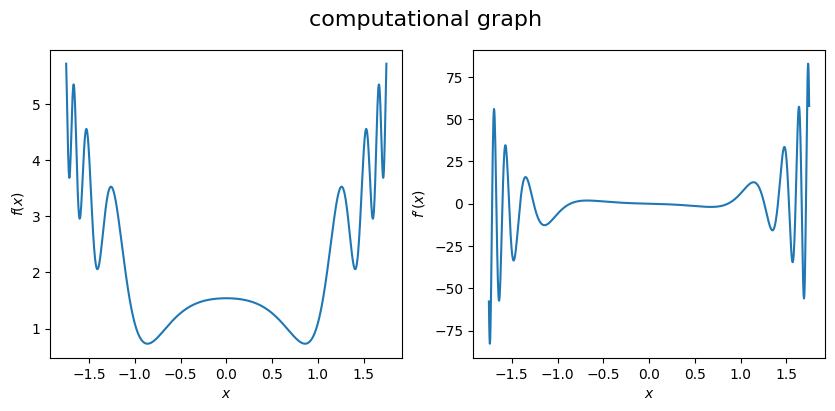

In [36]:
# compute derivative with computational graph for a range of x values and plot

x_arr = np.linspace(-1.75, 1.75, 1000)
y_arr = []
dy_dx_arr = []
for x_val in x_arr:
    x.output = x_val
    y_arr.append(o.forward())
    
    o.backward()
    dy_dx_arr.append(g3.grads_[x])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(x_arr, y_arr)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$f(x)$")

ax2.plot(x_arr, dy_dx_arr)
ax2.set_xlabel("$x$")
ax2.set_ylabel("$f^\prime(x)$")

fig.suptitle('computational graph', fontsize=16);

The plots of the original function computed with the forward pass in a dougnet computational graph and its derivative computed with the backward pass in a dougnet computational graph are exactly the same as the analagous plots which have been computed symbolically.

# MNIST MLP on a computational graph

In this section I illustrate how to train a simple MLP on a computational graph with both dougnet and pytorch (for comparison).  I use the same architecture and same seeds as the MLP used to train dougnet's MultiLayerPerceptron class (which does not use a computational graph) in notebook 1.  All three computations (dougnet, pytorch and the MultiLayerPerceptron class) achieve the same results.

### load/prep data

In [9]:
def PrepareData(X, y, n_classes, dtype=np.float32, seed=42, standardize=True):
    # one hot encode Ys
    Y_ohe = np.zeros((y.size, n_classes))
    Y_ohe[np.arange(y.size), y] = 1
    
    # standardize
    if standardize:
        X = ((X / 255.) - .5) * 2

    #transpose data 
    X = X.T
    Y_ohe = Y_ohe.T

    ## randomly shuffle columns (examples)
    random_perm_of_cols = np.random.RandomState(seed=seed).permutation(X.shape[1])
    X = X[:, random_perm_of_cols]
    Y_ohe = Y_ohe[:, random_perm_of_cols]
    
    return X.astype(dtype), Y_ohe.astype(dtype)

X_train, Y_train, X_val, Y_val = LoadMNIST()
X_train, Y_train = PrepareData(X_train, Y_train, 10, dtype=np.float64)
X_val, Y_val = PrepareData(X_val, Y_val, 10, dtype=np.float64)

### train MLP in dougnet

In [10]:
# define model in dougnet

LMBDA = 0.01

# instantiate computation graph data structure
graph = dn.ComputationGraph()

# instantiate data nodes
X = dn.InputNode()
Y = dn.InputNode()

# first hidden layer
W1 = dn.WeightNode(40, 28 * 28, dtype=np.float64)
b1 = dn.BiasNode(40, dtype=np.float64)
A1 = dn.Tanh(W1 @ X + b1)

# second hidden layer
W2 = dn.WeightNode(40, 40, dtype=np.float64)
b2 = dn.BiasNode(40, dtype=np.float64)
A2 = dn.Relu(W2 @ A1 + b2)

# output layer
W3 = dn.WeightNode(10, 40, dtype=np.float64)
b3 = dn.BiasNode(10, dtype=np.float64)
Z = W3 @ A2 + b3

# loss node
L_data = dn.SoftmaxCrossEntropyLoss(Z, Y)
L = L_data + dn.L2RegLoss(W1, W2, W3, lmbda=LMBDA)

In [11]:
# train dougnet model

EPOCHS = 100
BATCH_SIZE = 100
ETA = 0.01
SEED_WEIGHTS = 1984
SEED_DATALOADER = 2

# initialize weights
graph.initialize_params(SEED_WEIGHTS)
print(f"number of model parameters: {len(graph)}")

# copy initialized weights to be used with pytorch
weight1 = graph.parameters[0].output.copy()
weight2 = graph.parameters[2].output.copy()
weight3 = graph.parameters[4].output.copy()

progress = ProgressHelper(EPOCHS, X, Y, Z, L_data, progress_metric=accuracy)
dataloader = DataLoader(X_train, Y_train, BATCH_SIZE, random_state=SEED_DATALOADER)
for epoch in range(EPOCHS):

    # perform mini batch updates to parameters
    for X_B, Y_B in dataloader.load():
        X.output, Y.output = X_B, Y_B

        # run forward and backward methods
        _ = L.forward()
        L.backward()

        # update parameters 
        for parameter in graph.parameters:
            parameter.output -= ETA * graph.grads_[parameter]

    # update progress helper
    progress.update(X_train, Y_train, X_val, Y_val)

number of model parameters: 33450


epoch: 100%|███████████████| 100/100 [02:18<00:00,  1.39s/epoch, loss=0.2/0.2, score=0.95/0.95]              


### train MLP in pytorch

In [13]:
# load and prepare equivalent data for pytorch

X_train, Y_train, X_val, Y_val = LoadMNIST()
X_train, Y_train = PrepareData(X_train, Y_train, 10, dtype=np.float32)
X_val, Y_val = PrepareData(X_val, Y_val, 10, dtype=np.float32)

# de-OHE ys
Y_train = np.argmax(Y_train, axis=0).astype(np.int64)
Y_val = np.argmax(Y_val, axis=0).astype(np.int64)

# turn data into tensors
X_train_tensor = torch.tensor(X_train.T)
Y_train_tensor = torch.tensor(Y_train.reshape(-1), dtype=torch.long)

X_val_tensor = torch.tensor(X_val.T)
Y_val_tensor = torch.tensor(Y_val.reshape(-1), dtype=torch.long)

In [14]:
# define pytorch model

model_pytorch = nn.Sequential(
    nn.Linear(784,40),
    nn.Tanh(),
    nn.Linear(40,40),
    nn.ReLU(),
    nn.Linear(40,10)
)

# initialize weights with same initial values as before
with torch.no_grad():
    model_pytorch[0].weight = nn.Parameter(torch.tensor(weight1.astype(np.float32)))
    model_pytorch[0].bias = nn.Parameter(torch.zeros(40))
    
    model_pytorch[2].weight = nn.Parameter(torch.tensor(weight2.astype(np.float32)))
    model_pytorch[2].bias = nn.Parameter(torch.zeros(40))
    
    model_pytorch[4].weight = nn.Parameter(torch.tensor(weight3.astype(np.float32)))
    model_pytorch[4].bias = nn.Parameter(torch.zeros(10))

# turn off regularization of bias which is by default on in pytorch
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': [model_pytorch[0].weight, 
                model_pytorch[2].weight, 
                model_pytorch[4].weight], 
     'weight_decay': LMBDA}, 
    {'params': [model_pytorch[0].bias, 
                model_pytorch[2].bias, 
                model_pytorch[4].bias],
     'weight_decay': 0}], lr=ETA)

In [15]:
%%time

loss_train = []
accuracy_train = []
loss_val = []
accuracy_val = []
def record_progress():
    """func to record training progress"""
    with torch.no_grad():
        # record train loss
        yhat_train = model_pytorch(X_train_tensor)
        loss_train.append(loss_fn(yhat_train, Y_train_tensor).item())    

        # record train accuracy
        is_correct = (torch.argmax(yhat_train, dim=1) == Y_train_tensor).float()
        accuracy_train.append((is_correct.sum() / yhat_train.shape[0]).item())

        # record val loss
        yhat_val = model_pytorch(X_val_tensor)
        loss_val.append(loss_fn(yhat_val, Y_val_tensor).item())    

        # record train accuracy
        is_correct = (torch.argmax(yhat_val, dim=1) == Y_val_tensor).float()
        accuracy_val.append((is_correct.sum() / yhat_val.shape[0]).item())

        
# train
dataloader = DataLoader(X_train, Y_train, BATCH_SIZE, random_state=SEED_DATALOADER)
for epoch in range(EPOCHS):
    for X_B, Y_B in dataloader.load():
        
        X_B_tensor = torch.tensor(X_B.T)
        Y_B_tensor = torch.tensor(Y_B.reshape(-1), dtype=torch.long)
                
        yhat = model_pytorch(X_B_tensor)
        loss = loss_fn(yhat, Y_B_tensor)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    record_progress()

CPU times: user 1min 13s, sys: 34.1 s, total: 1min 48s
Wall time: 1min 26s


### compare

In [19]:
print(f"Training loss: (pytorch, dougnet) = ({round(loss_train[-1], 3)}, {round(progress.loss_train_[-1], 3)})")
print(f"Validation loss: (pytorch, dougnet) = ({round(loss_val[-1], 3)}, {round(progress.loss_val_[-1], 3)})")

print(f"Training accuracy: (pytorch, dougnet) = ({round(accuracy_train[-1], 3)}, {round(progress.score_train_[-1], 3)})")
print(f"Validation accuracy: (pytorch, dougnet) = ({round(accuracy_val[-1], 3)}, {round(progress.score_val_[-1], 3)})")

Training loss: (pytorch, dougnet) = (0.204, 0.203)
Validation loss: (pytorch, dougnet) = (0.204, 0.204)
Training accuracy: (pytorch, dougnet) = (0.95, 0.949)
Validation accuracy: (pytorch, dougnet) = (0.947, 0.947)


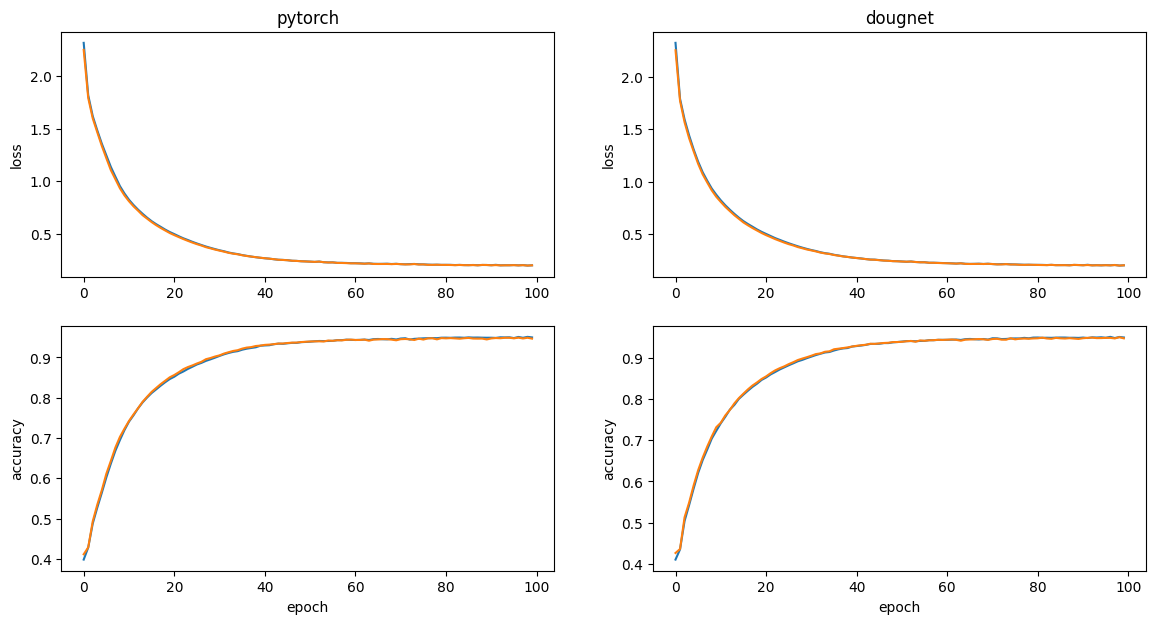

In [18]:
# plot progress during training for both dougnet and pytorch

fig, ax = plt.subplots(2, 2, figsize=(14, 7))

ax[0][0].plot(range(EPOCHS), loss_train)
ax[0][0].plot(range(EPOCHS), loss_val)
ax[0][0].set_ylabel("loss")
ax[0][0].set_title("pytorch")

ax[1][0].plot(range(EPOCHS), accuracy_train)
ax[1][0].plot(range(EPOCHS), accuracy_val)
ax[1][0].set_ylabel("accuracy")
ax[1][0].set_xlabel("epoch")


ax[0][1].plot(range(EPOCHS), progress.loss_train_)
ax[0][1].plot(range(EPOCHS), progress.loss_val_)
ax[0][1].set_ylabel("loss")
ax[0][1].set_title("dougnet")

ax[1][1].plot(range(EPOCHS), progress.score_train_)
ax[1][1].plot(range(EPOCHS), progress.score_val_)
ax[1][1].set_ylabel("accuracy")
ax[1][1].set_xlabel("epoch");

# Noisy sin data MLP on a computational graph
As a final example, I re-train the noisy sin data MLP introduced in notebook 1 on dougnet's computational graph and compare the results.


In [20]:
# create noisy sine data

f = lambda x: np.sin(x)
low, high = -10, 10

np.random.seed(2021)
X_train = np.random.uniform(low, high, 1000).reshape(1, 1000)
Y_train = f(X_train) + np.random.normal(0, .1, 1000).reshape(1, 1000)

X_val = np.random.uniform(low, high, 100).reshape(1, 100)
Y_val = f(X_val) + np.random.normal(0, .1, 100).reshape(1, 100)

X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_val = Y_val.astype(np.float32)

### train with the MultiLayerPerceptron class

In [21]:
LMBDA = .1
ETA = .0005
EPOCHS = 200
SEED_WEIGHT = 1984
SEED_DATA = 2
BATCH_SIZE = 100

mlp_sin = MultiLayerPerceptron([100, 100, 1], 
                               [tanh, tanh, identity], 
                               reg_loss=l2regloss, 
                               lmbda=LMBDA,
                               eta=ETA,
                               n_epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               weight_seed=SEED_WEIGHT,
                               data_seed=SEED_DATA, 
                               progress_metric=r2,
                               loss=l2loss,
                               verbose=True)

mlp_sin.fit(X_train, Y_train, X_val, Y_val);

epoch: 100%|███████████████| 200/200 [00:06<00:00, 30.91epoch/s, loss=0.04/0.05, score=0.75/0.65, tra


### train with dougnet computational graph
Like pytorch, dougnet implements a `module` class which allows for multiple lines of code defining computations in a dougnet graph to be packaged into a single object.  `dn.Linear` is an example of a module class which performs an affine transformation.  As with pytorch, it is convenient to package entire neural network models in a dougnet module.  For continuity, the code in this section does not package the MLP in a dougnet module, however, the equivalent MLP module would be:

```
class MLP(dn.module):

    def __init__(self):
        self.X = dn.InputNode()
        super().__init__()

    def forward_(self):
        Z1 = dn.Linear(self.X, 100, 1)
        A1 = dn.Tanh(Z1.module_output)
        
        Z2 = dn.Linear(A1, 100, 100)
        A2 = dn.Tanh(Z2.module_output)
        
        return dn.Linear(A2, 1, 100).module_output
```

In [22]:
# train a dougnet model 
        
# define model
model = dn.ComputationGraph()

X = dn.InputNode()
Y = dn.InputNode()

Z1 = dn.Linear(X, 100, 1)
A1 = dn.Tanh(Z1.module_output)

Z2 = dn.Linear(A1, 100, 100)
A2 = dn.Tanh(Z2.module_output)

Z = dn.Linear(A2, 1, 100)

# regularize bias weights as well for comparison to pytorch (pytorch regularizes bias)
L_data = dn.L2Loss(Z.module_output, Y)
L = L_data + dn.L2RegLoss(Z1.weight, Z2.weight, Z.weight, lmbda=LMBDA)

# initialize weights
model.initialize_params(SEED_WEIGHT)
weight1 = Z1.weight.output.copy()
weight2 = Z2.weight.output.copy()
weight3 = Z.weight.output.copy()


# train
progress = ProgressHelper(EPOCHS, X, Y, Z.module_output, L_data, progress_metric=r2)
dataloader = DataLoader(X_train, Y_train, BATCH_SIZE, random_state=SEED_DATA)
for epoch in range(EPOCHS):

    # perform mini batch updates to parameters
    for X_B, Y_B in dataloader.load():
        X.output, Y.output = X_B, Y_B

        # run forward and backward methods
        _ = L.forward()
        L.backward()

        # update parameters 
        for parameter in model.parameters:
            parameter.output -= ETA * model.grads_[parameter]

    # update progress helper
    progress.update(X_train, Y_train, X_val, Y_val)

epoch: 100%|███████████████| 200/200 [00:06<00:00, 29.99epoch/s, loss=0.04/0.05, score=0.75/0.65, tra


### train with pytorch

In [23]:
# define pytorch model
model_pytorch = nn.Sequential(
    nn.Linear(1,100),
    nn.Tanh(),
    nn.Linear(100,100),
    nn.Tanh(),
    nn.Linear(100,1)
)

# initialize model weights with same weights as previous models
with torch.no_grad():
    model_pytorch[0].weight = nn.Parameter(torch.tensor(weight1))
    model_pytorch[0].bias = nn.Parameter(torch.zeros(100))
    
    model_pytorch[2].weight = nn.Parameter(torch.tensor(weight2))
    model_pytorch[2].bias = nn.Parameter(torch.zeros(100))
    
    model_pytorch[4].weight = nn.Parameter(torch.tensor(weight3))
    model_pytorch[4].bias = nn.Parameter(torch.zeros(1))
    
    
# train (turn off regularization of bias which is by default on in pytorch)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD([
    {'params': [model_pytorch[0].weight, 
                model_pytorch[2].weight, 
                model_pytorch[4].weight], 
     'weight_decay': LMBDA}, 
    {'params': [model_pytorch[0].bias, 
                model_pytorch[2].bias, 
                model_pytorch[4].bias],
     'weight_decay': 0}], lr=ETA)
dataloader = DataLoader(X_train, Y_train, BATCH_SIZE, random_state=SEED_DATA)
for epoch in range(EPOCHS):
    for X_B, Y_B in dataloader.load():
        
        X_B_tensor = torch.tensor(X_B.T)
        Y_B_tensor = torch.tensor(Y_B.reshape(-1))
                
        yhat = model_pytorch(X_B_tensor)
        loss = loss_fn(yhat.reshape(-1), Y_B_tensor)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

### compare

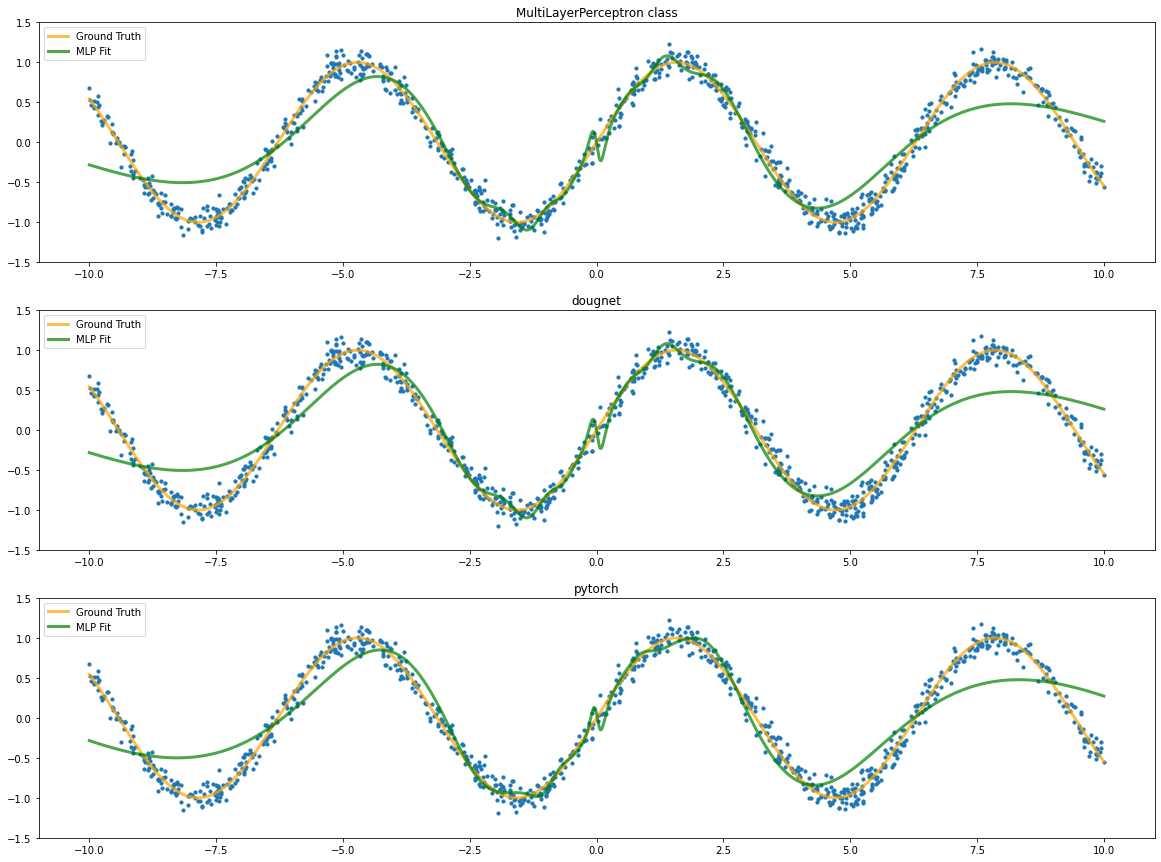

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
x = np.linspace(low, high, 1000).reshape(1, 1000)
y = f(x).reshape(1, 1000)

# plot results from MultiLayerPerceptron class
axs[0].scatter(X_train, Y_train, s=10)
axs[0].plot(x.reshape(1000), y.reshape(1000), color='orange', linewidth=3, 
         label='Ground Truth', alpha=.7)
axs[0].plot(x.reshape(1000), mlp_sin.predict(x).reshape(1000), color='green', 
         linewidth=3, label='MLP Fit', alpha=.7)
axs[0].legend(loc="upper left")
axs[0].set_ylim((-1.5, 1.5))
axs[0].set_title("MultiLayerPerceptron class")


# plot results from dougnet
X.output = x
axs[1].scatter(X_train, Y_train, s=10)
axs[1].plot(x.reshape(1000), y.reshape(1000), color='orange', linewidth=3, 
         label='Ground Truth', alpha=.7)
axs[1].plot(x.reshape(1000), Z.forward().reshape(1000), color='green', 
         linewidth=3, label='MLP Fit', alpha=.7)
axs[1].legend(loc="upper left")
axs[1].set_ylim((-1.5, 1.5))
axs[1].set_title("dougnet")


# plot results from pytorch
x_torch = torch.linspace(low, high, 1000).reshape(-1, 1)
with torch.no_grad():
    axs[2].scatter(X_train, Y_train, s=10)
    axs[2].plot(x.reshape(1000), y.reshape(1000), color='orange', linewidth=3, 
             label='Ground Truth', alpha=.7)
    axs[2].plot(x.reshape(1000), model_pytorch(x_torch).reshape(1000), color='green', 
             linewidth=3, label='MLP Fit', alpha=.7)
    axs[2].legend(loc="upper left")
    axs[2].set_ylim((-1.5, 1.5))
    axs[2].set_title("pytorch");